In [1]:
# linear algebra
import numpy as np 

# data processing
import pandas as pd 

# data visualization
import seaborn as sns
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import style

# Algorithms
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import GaussianNB

In [9]:
test_df = pd.read_csv("data/test.csv")
train_df = pd.read_csv("data/train.csv")

In [10]:
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## Valores ausentes

In [11]:
total = train_df.isnull().sum().sort_values(ascending=False)
percent_1 = train_df.isnull().sum()/train_df.isnull().count()*100
percent_2 = (round(percent_1, 1)).sort_values(ascending=False)
missing_data = pd.concat([total, percent_2], axis=1, keys=['Total', '%'])
missing_data.head(5)

,Total,%
Cabin,687,77.1
Age,177,19.9
Embarked,2,0.2
Fare,0,0.0
Ticket,0,0.0



O recurso Embarcado tem apenas dois valores ausentes, que podem ser facilmente preenchidos. Será muito mais complicado lidar com o recurso 'Age', que tem 177 valores em falta. O recurso 'Cabin' precisa de uma investigação mais aprofundada, mas parece que podemos querer abandoná-lo do conjunto de dados, já que 77% dele está faltando

## Idade e seco

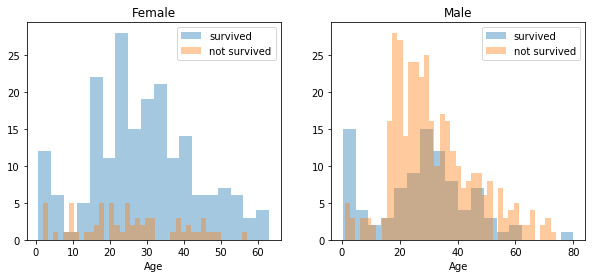

In [12]:
survived = 'survived'
not_survived = 'not survived'
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(10, 4))
women = train_df[train_df['Sex']=='female']
men = train_df[train_df['Sex']=='male']
ax = sns.distplot(women[women['Survived']==1].Age.dropna(), bins=18, label = survived, ax = axes[0], kde =False)
ax = sns.distplot(women[women['Survived']==0].Age.dropna(), bins=40, label = not_survived, ax = axes[0], kde =False)
ax.legend()
ax.set_title('Female')
ax = sns.distplot(men[men['Survived']==1].Age.dropna(), bins=18, label = survived, ax = axes[1], kde = False)
ax = sns.distplot(men[men['Survived']==0].Age.dropna(), bins=40, label = not_survived, ax = axes[1], kde = False)
ax.legend()
_ = ax.set_title('Male')

Podemos ver que os homens têm uma alta probabilidade de sobrevivência quando têm entre 18 e 30 anos, o que também é um pouco verdadeiro para as mulheres, mas não totalmente. Para as mulheres, as chances de sobrevivência são maiores entre 14 e 40 anos.

In [13]:
train_df = train_df.drop(['PassengerId'], axis=1)

In [14]:
train_df = train_df.drop(['Cabin'], axis=1)
test_df = test_df.drop(['Cabin'], axis=1)

Para resolver o problema com os valores ausentes da faixa etária. Criaremos uma matriz que contém números aleatórios, que são calculados com base no valor médio de idade em relação ao desvio padrão e is_null.

In [15]:
data = [train_df, test_df]

for dataset in data:
    mean = train_df["Age"].mean()
    std = test_df["Age"].std()
    is_null = dataset["Age"].isnull().sum()
    # compute random numbers between the mean, std and is_null
    rand_age = np.random.randint(mean - std, mean + std, size = is_null)
    # fill NaN values in Age column with random values generated
    age_slice = dataset["Age"].copy()
    age_slice[np.isnan(age_slice)] = rand_age
    dataset["Age"] = age_slice
    dataset["Age"] = train_df["Age"].astype(int)

train_df["Age"].isnull().sum()

0

Como o recurso Embarcado tem apenas dois valores ausentes, apenas os preencheremos com o mais comum.

In [16]:
train_df['Embarked'].describe()

count     889
unique      3
top         S
freq      644
Name: Embarked, dtype: object

In [17]:
common_value = 'S'
data = [train_df, test_df]

for dataset in data:
    dataset['Embarked'] = dataset['Embarked'].fillna(common_value)

## Convertendo tipos

In [18]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 10 columns):
Survived    891 non-null int64
Pclass      891 non-null int64
Name        891 non-null object
Sex         891 non-null object
Age         891 non-null int32
SibSp       891 non-null int64
Parch       891 non-null int64
Ticket      891 non-null object
Fare        891 non-null float64
Embarked    891 non-null object
dtypes: float64(1), int32(1), int64(4), object(4)
memory usage: 52.2+ KB


Converter Fare para int64

In [19]:
data = [train_df, test_df]

for dataset in data:
    dataset['Fare'] = dataset['Fare'].fillna(0)
    dataset['Fare'] = dataset['Fare'].astype(int)

Usaremos o recurso Nome para extrair os Títulos do Nome, para que possamos criar um novo recurso a partir disso.

In [20]:
data = [train_df, test_df]
titles = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}

for dataset in data:
    # extract titles
    dataset['Title'] = dataset.Name.str.extract(' ([A-Za-z]+)\.', expand=False)
    # replace titles with a more common title or as Rare
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr',\
                                            'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')
    # convert titles into numbers
    dataset['Title'] = dataset['Title'].map(titles)
    # filling NaN with 0, to get safe
    dataset['Title'] = dataset['Title'].fillna(0)
    


train_df = train_df.drop(['Name'], axis=1)
test_df = test_df.drop(['Name'], axis=1)

In [21]:
train_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Title
0,0,3,male,22,1,0,A/5 21171,7,S,1
1,1,1,female,38,1,0,PC 17599,71,C,3
2,1,3,female,26,0,0,STON/O2. 3101282,7,S,2
3,1,1,female,35,1,0,113803,53,S,3
4,0,3,male,35,0,0,373450,8,S,1


Sexos serão substiruidos por valores numericos

In [22]:
genders = {"male": 0, "female": 1}
data = [train_df, test_df]

for dataset in data:
    dataset['Sex'] = dataset['Sex'].map(genders)

In [23]:
train_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Title
0,0,3,0,22,1,0,A/5 21171,7,S,1
1,1,1,1,38,1,0,PC 17599,71,C,3
2,1,3,1,26,0,0,STON/O2. 3101282,7,S,2
3,1,1,1,35,1,0,113803,53,S,3
4,0,3,0,35,0,0,373450,8,S,1


In [24]:
train_df['Ticket'].describe()

count      891
unique     681
top       1601
freq         7
Name: Ticket, dtype: object

Como o atributo Ticket tem 681 tickets únicos, será um pouco complicado convertê-los em categorias úteis, então será removido do conjunto de treino

In [25]:
train_df = train_df.drop(['Ticket'], axis=1)
test_df = test_df.drop(['Ticket'], axis=1)

Converter Embarked para valores numericos

In [26]:
ports = {"S": 0, "C": 1, "Q": 2}
data = [train_df, test_df]

for dataset in data:
    dataset['Embarked'] = dataset['Embarked'].map(ports)

In [27]:
train_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,0,3,0,22,1,0,7,0,1
1,1,1,1,38,1,0,71,1,3
2,1,3,1,26,0,0,7,0,2
3,1,1,1,35,1,0,53,0,3
4,0,3,0,35,0,0,8,0,1


## Binning Encoder



In [28]:
data = [train_df, test_df]
for dataset in data:
    dataset['Age'] = dataset['Age'].astype(int)
    dataset.loc[ dataset['Age'] <= 11, 'Age'] = 0
    dataset.loc[(dataset['Age'] > 11) & (dataset['Age'] <= 18), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 18) & (dataset['Age'] <= 22), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 22) & (dataset['Age'] <= 27), 'Age'] = 3
    dataset.loc[(dataset['Age'] > 27) & (dataset['Age'] <= 33), 'Age'] = 4
    dataset.loc[(dataset['Age'] > 33) & (dataset['Age'] <= 40), 'Age'] = 5
    dataset.loc[(dataset['Age'] > 40) & (dataset['Age'] <= 66), 'Age'] = 6
    dataset.loc[ dataset['Age'] > 66, 'Age'] = 6

In [29]:
train_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,0,3,0,2,1,0,7,0,1
1,1,1,1,5,1,0,71,1,3
2,1,3,1,3,0,0,7,0,2
3,1,1,1,5,1,0,53,0,3
4,0,3,0,5,0,0,8,0,1


In [30]:
data = [train_df, test_df]

for dataset in data:
    dataset.loc[ dataset['Fare'] <= 7.91, 'Fare'] = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare']   = 2
    dataset.loc[(dataset['Fare'] > 31) & (dataset['Fare'] <= 99), 'Fare']   = 3
    dataset.loc[(dataset['Fare'] > 99) & (dataset['Fare'] <= 250), 'Fare']   = 4
    dataset.loc[ dataset['Fare'] > 250, 'Fare'] = 5
    dataset['Fare'] = dataset['Fare'].astype(int)

In [31]:
train_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,0,3,0,2,1,0,0,0,1
1,1,1,1,5,1,0,3,1,3
2,1,3,1,3,0,0,0,0,2
3,1,1,1,5,1,0,3,0,3
4,0,3,0,5,0,0,1,0,1


# Training Model

In [32]:
X_train = train_df.drop("Survived", axis=1)
Y_train = train_df["Survived"]
X_test  = test_df.drop("PassengerId", axis=1).copy()

In [36]:
random_forest = RandomForestClassifier(n_estimators=100)
random_forest.fit(X_train, Y_train)

Y_pred = random_forest.predict(X_test)

random_forest.score(X_train, Y_train)
acc_random_forest = round(random_forest.score(X_train, Y_train) * 100, 2)
print(round(acc_random_forest,2,), "%")

91.13 %


In [ ]:
from sklearn.tree import export_graphviz

dot = export_graphviz(tree_clf,
                out_file='tree.dot',
                feature_names=df.columns[:-1],
                class_names=df['species'],
                rounded=True,
                filled=True)

# Convert to png using system command (requires Graphviz)
from subprocess import call
call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])

In [58]:
from sklearn.tree import export_graphviz

export_graphviz(random_forest[0],
               out_file='tree.dot',
                feature_names=X_train.columns,
                class_names=['Yes', 'No'],
                rounded=True,
                filled=True) 

# Convert to png using system command (requires Graphviz)
from subprocess import call
call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])

FileNotFoundError: [WinError 2] O sistema não pode encontrar o arquivo especificado

In [45]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
pred = cross_val_predict(random_forest, X_train, Y_train, cv=3)

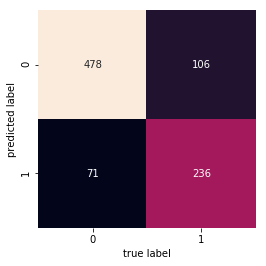

In [46]:
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(Y_train, pred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');